### Обработка временных рядов при помощи рекуррентных нейронных сетей

На данном семинаре мы попробуем использовать рекуррентную нейронную сеть для работы со временными рядами. Цель - имея ряд предыдущих значений временного ряда, предсказать следующее. Таким образом, мы сможем пошагово осуществлять прогнозирование.

Начнём с небольшого "игрушечного" примера. Мы сгенерируем искусственные данные и обучим на них сеть.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

%matplotlib inline

В качестве искусственных данных мы будем использовать синусоидальную волну. Вы также можете попоробовать обучить сеть для предсказания других данных. Желательно использовать функции, лежащие в интервале [-1, 1], иначе придётся изменять визуализацию.

In [13]:
N = 100 # Number of waves
T = 20 # Shift size
L = 1000 # Length of each wave

np.random.seed(1)
X = np.zeros((N, L), dtype=np.float64)
for i in range(len(X)):
    X[i,:] = np.arange(L) + np.random.randint(-T * 4, T * 4, 1) # Initializing X points for each wave
y = <Your code here> # Generate sine wave or use other function on X

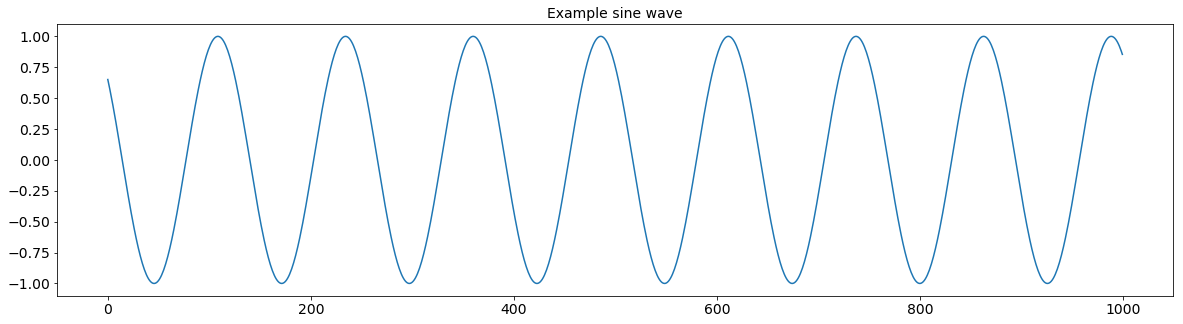

In [18]:
plt.figure(figsize=(20, 5))
plt.title("Example sine wave", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(y[42])

Далее, инициализируем сеть, которую будем использовать для предсказания. 

In [19]:
import torch
from torch import nn
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

class LSTM(nn.Module):
    def __init__(self, hidden_size=50):
        super(LSTM, self).__init__()
        self.lstm = <Your code here> # LSTM cell for processing the time series
        self.linear = <Your code here> # Linear layer to output the result
        self.hidden_size = hidden_size
        
    def forward(self, input, future=0):
        outputs = []
        h_t = Variable(torch.zeros(input.size(0), self.hidden_size))
        c_t = Variable(torch.zeros(input.size(0), self.hidden_size))
        
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
            
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

Теперь мы можем приступить к обучению модели. 3 волны будут использоваться в качестве тестовой выборки. Поскольку наша цель - предсказать следующее значение, во входные данные не будут включены последние точки волны, поскольку для них нет следующих, а в выходные - первые, поскольку для них нет предыдущих.

In [20]:
train_input = y[3:, :-1]
train_target = y[3:, 1:]
test_input = y[:3, :-1]
test_target = y[:3, 1:]

Определим сеть, используемые переменные, функцию потерь и оптимизатор.

In [26]:
batch_size = 50
epochs = 15

lstm = LSTM()
inp = Variable(torch.FloatTensor(batch_size, L))
target = Variable(torch.FloatTensor(batch_size, L))

if use_cuda:
    lstm.cuda()
    inp.cuda()
    target.cuda()

lstm_opt = torch.optim.LBFGS(lstm.parameters())
lstm_loss = <Your code here>

Определим функции для итерации батчей и предсказания последующих значений.

In [27]:
def iterate_minibatches(x, y, batch_size = 32, verbose = True):
    indices = np.random.permutation(np.arange(len(x)))
    batches = range(0, len(x), batch_size)
    if verbose: 
        batches = tqdm(batches)
    return ((torch.from_numpy(x[indices[start_idx:start_idx + batch_size]]),
            torch.from_numpy(y[indices[start_idx:start_idx + batch_size]])) for start_idx in batches)

def predict(x_test, y_test, future=1000):
    lstm.eval()
    x_test = torch.from_numpy(x_test)
    y_test = torch.from_numpy(y_test)
    inp.data.resize_(x_test.size()).copy_(x_test)
    target.data.resize_(y_test.size()).copy_(y_test)
    pred = lstm(inp, future=future)
    err = lstm_loss(pred[:, :-future], target)
    y = pred.data.numpy()
    return y, err.data[0]

Обучим сеть, дополнительно наблюдая за динамикой обучения.


100%|██████████| 2/2 [00:45<00:00, 23.54s/it]


#1, Train loss: 0.1036404
#1, Test loss: 0.0000985


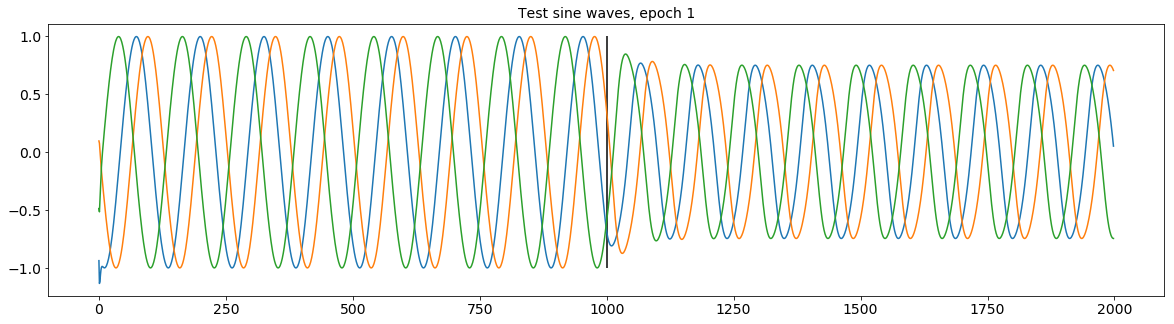

  0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [28]:
for epoch in range(epochs):
    losses = []
    for (x_batch, y_batch) in iterate_minibatches(train_input, train_target, batch_size=batch_size):
        def closure():
            lstm.zero_grad()
            inp.data.resize_(x_batch.size()).copy_(x_batch)
            target.data.resize_(y_batch.size()).copy_(y_batch)
            out = <Your code here>
            err = <Your code here>
            err.backward()
            losses.append(err.data[0])
            return err
        lstm_opt.step(closure)
    pred, test_loss = predict(test_input, test_target)
    print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)
    print("#%i, Test loss: %.7f"%(epoch+1,np.mean(test_loss)),flush=True)
    # Plotting the result
    plt.figure(figsize=(20, 5))
    plt.title("Test sine waves, epoch %i"%(epoch+1), fontsize=14)
    plt.plot(pred.T)
    plt.vlines(1000, -1, 1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

### Предсказываем погоду

Попробуем решить задачу, более приближенную к реальности. Используя набор данных о минимальной дневной температуре в Мельбурне, попробуем восстановить недостающие значения.

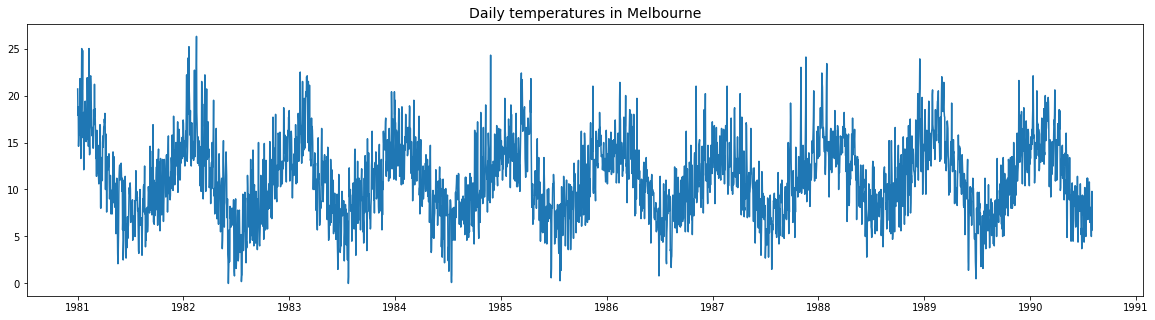

In [61]:
data = <Your code here>
plt.figure(figsize=(20, 5))
plt.title("Daily temperatures in Melbourne", fontsize=14)
plt.plot_date(data["Date"], data["Temp"], fmt='-');

Для упрощения процесса обучения и обработки данных разделим выборку на сегменты длиной в 100 дней, и предположим, что данные для 20 последних дней в каждом сегменте были утеряны.

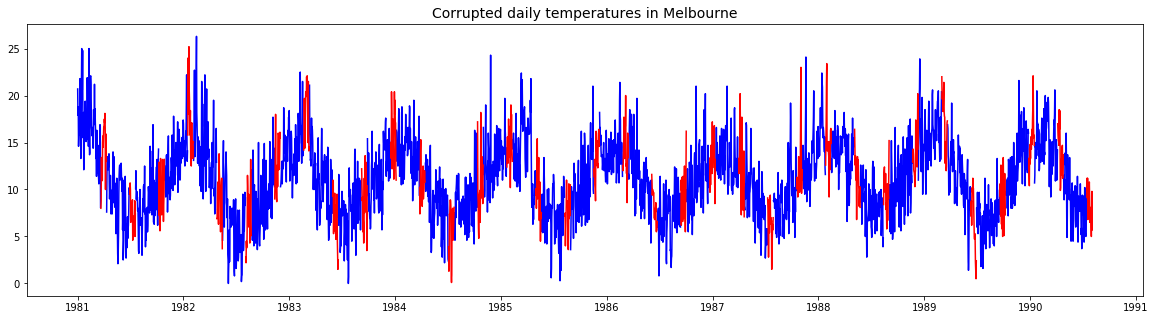

In [119]:
start_inds = np.arange(0, len(data), 100)
x_train = np.array([data["Temp"][start_ind: start_ind+80] for start_ind in start_inds])
x_test = np.array([data["Temp"][start_ind+80: start_ind+100] for start_ind in start_inds])

train_input = x_train[:, :-1]
train_target = x_train[:, 1:]

date_train = np.array([data["Date"][start_ind: start_ind+80] for start_ind in start_inds])
date_test = np.array([data["Date"][start_ind+80: start_ind+100] for start_ind in start_inds])

plt.figure(figsize=(20, 5))
plt.title("Corrupted daily temperatures in Melbourne", fontsize=14)
for dates, temps in zip(date_train, x_train):
    plt.plot_date(dates, temps, fmt='b-')
for dates, temps in zip(date_test, x_test):
    plt.plot_date(dates, temps, fmt='r-')

Попробуем применить усложнённую архитектуру для обучения и предсказания.

In [120]:
class LSTM2(nn.Module):
    def __init__(self, hidden_size=50):
        super(LSTM2, self).__init__()
        self.lstm_1 = <Your code here> # LSTM cell for processing the time series
        self.lstm_2 = <Your code here> # Second LSTM to strenghten the network
        self.linear = <Your code here> # Linear layer to output the result
        self.hidden_size = hidden_size
        
    def forward(self, input, future=0):
        outputs = []
        h_t_1 = Variable(torch.zeros(input.size(0), self.hidden_size))
        c_t_1 = Variable(torch.zeros(input.size(0), self.hidden_size))
        h_t_2 = Variable(torch.zeros(input.size(0), self.hidden_size))
        c_t_2 = Variable(torch.zeros(input.size(0), self.hidden_size))
        
        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t_1, c_t_1 = self.lstm_1(input_t, (h_t_1, c_t_1))
            h_t_2, c_t_2 = self.lstm_2(h_t_1, (h_t_2, c_t_2))
            output = self.linear(h_t_2)
            outputs += [output]
            
        for i in range(future):# if we should predict the future
            h_t_1, c_t_1 = self.lstm_1(output, (h_t_1, c_t_1))
            h_t_2, c_t_2 = self.lstm_2(h_t_1, (h_t_2, c_t_2))
            output = self.linear(h_t_2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [121]:
batch_size = 50
epochs = 15

lstm = LSTM2(128)
inp = Variable(torch.FloatTensor(batch_size, L))
target = Variable(torch.FloatTensor(batch_size, L))

if use_cuda:
    lstm.cuda()
    inp.cuda()
    target.cuda()

lstm_opt = torch.optim.LBFGS(lstm.parameters())
lstm_loss = <Your code here>

Изменим функцию predict, чтобы она считала ошибку только для предсказанных участков.

In [122]:
def predict(x_test, y_test, future=20):
    lstm.eval()
    x_test = torch.from_numpy(x_test)
    y_test = torch.from_numpy(y_test)
    inp.data.resize_(x_test.size()).copy_(x_test)
    target.data.resize_(y_test.size()).copy_(y_test)
    pred = lstm(inp, future=future)
    err = lstm_loss(pred[:, -future:], target)
    y = pred.data.numpy()
    return y[:, -future:], err.data.numpy()

100%|██████████| 1/1 [00:08<00:00,  8.07s/it]


#1, Train loss: 5.7683930
#1, Test loss: 9.3066759


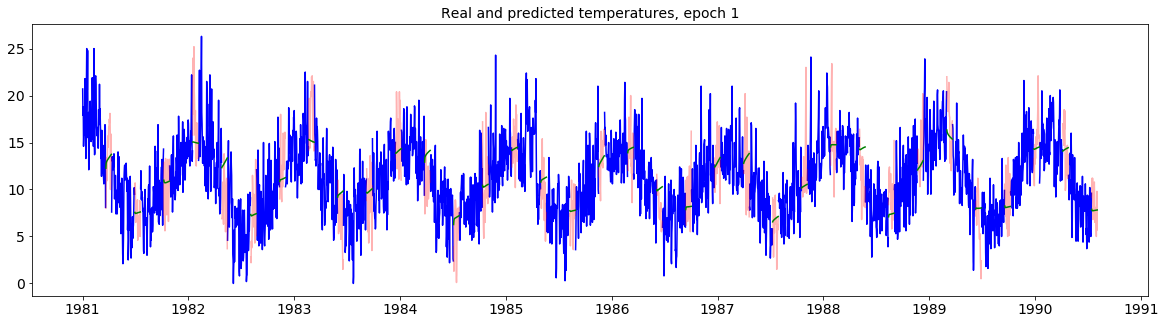

100%|██████████| 1/1 [00:08<00:00,  8.01s/it]


#2, Train loss: 5.7214504
#2, Test loss: 9.4132986


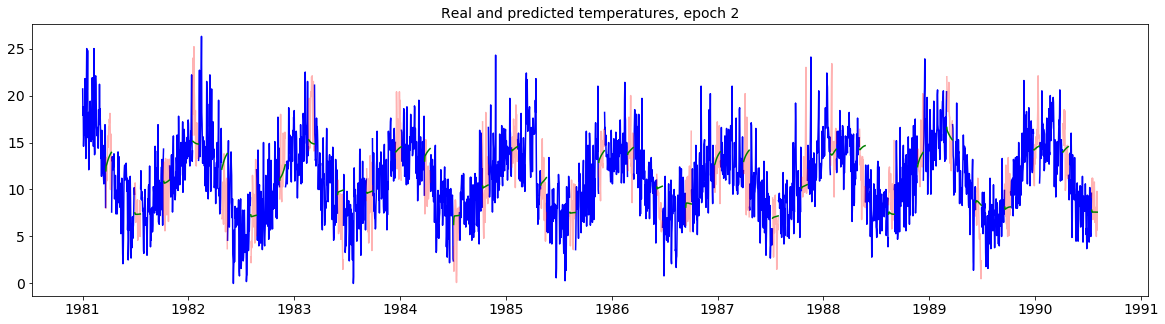

100%|██████████| 1/1 [00:08<00:00,  8.25s/it]


#3, Train loss: 5.6755797
#3, Test loss: 9.2046795


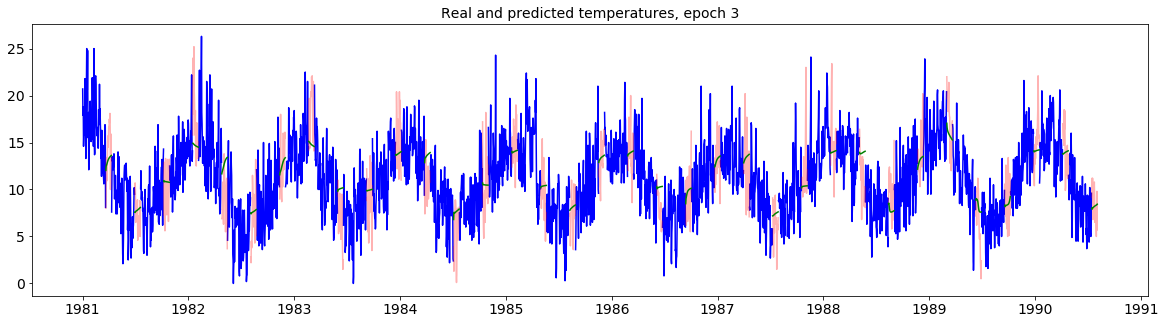

100%|██████████| 1/1 [00:08<00:00,  8.18s/it]


#4, Train loss: 5.6154439
#4, Test loss: 9.4049292


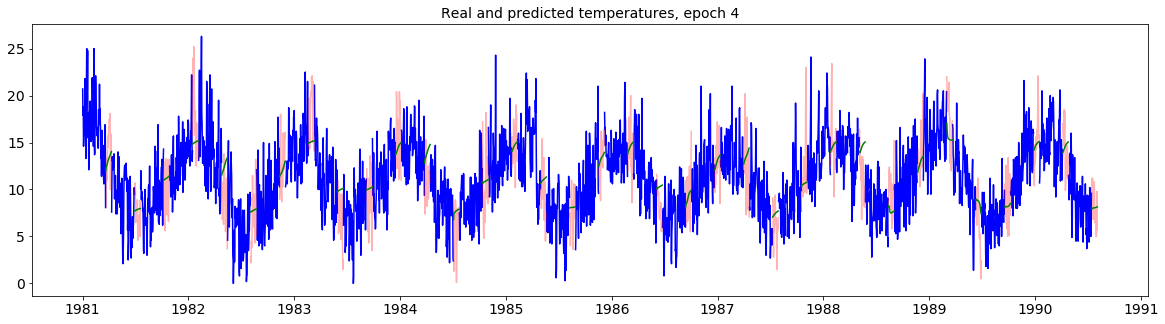

100%|██████████| 1/1 [00:08<00:00,  8.32s/it]


#5, Train loss: 5.5653554
#5, Test loss: 9.4356194


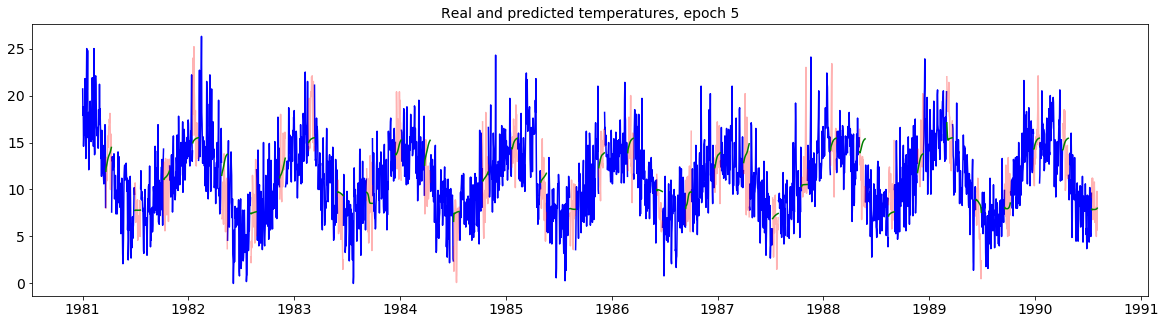

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
for epoch in range(epochs):
    losses = []
    for (x_batch, y_batch) in iterate_minibatches(train_input, train_target, batch_size=batch_size):
        def closure():
            lstm.zero_grad()
            inp.data.resize_(x_batch.size()).copy_(x_batch)
            target.data.resize_(y_batch.size()).copy_(y_batch)
            out = lstm(inp)
            err = lstm_loss(out, target)
            err.backward()
            losses.append(err.data.numpy())
            return err
        lstm_opt.step(closure)
    pred, test_loss = predict(x_train, x_test, future=20)
    print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)
    print("#%i, Test loss: %.7f"%(epoch+1,np.mean(test_loss)),flush=True)
    # Plotting the result
    plt.figure(figsize=(20, 5))
    plt.title("Real and predicted temperatures, epoch %i"%(epoch+1), fontsize=14)
    for dates, temps in zip(date_train, x_train):
        plt.plot_date(dates, temps, fmt='b-')
    for dates, temps in zip(date_test, x_test):
        plt.plot_date(dates, temps, fmt='r-', alpha=0.3)
    for dates, temps in zip(date_test, pred):
        plt.plot_date(dates, temps, fmt='g-')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

Попробуйте применить полученные знания, чтобы улучшить результат.